In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-10-03 23:46:46,818 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

# paths_train = glob('../submit/re_sub/50*_train.gz')
# paths_test  = glob('../submit/re_sub/50*_test.gz')
# paths_train += glob('../submit/re_sub/Tran*_train.gz')
# paths_test  += glob('../submit/re_sub/Tran*_test.gz')
# paths_train += glob('../submit/re_sub/is*_train.gz')
# paths_test  += glob('../submit/re_sub/is*_test.gz')

paths_train = glob('../submit/re_sub/*_train.gz')
paths_test  = glob('../submit/re_sub/*_test.gz')
# paths_train += glob('../submit/add_feature/*_train.gz')
# paths_test  += glob('../submit/add_feature/*_test.gz')

print(len(paths_train))
# sys.exit()
# paths_train += glob('../feature/valid_trush/528*uid2*_train.gz')
# paths_test  += glob('../feature/valid_trush/528*uid2*_test.gz')

# for path in paths_train:
#     if path.count('C14_ratio'):
#         paths_train.remove(path)
        
# for path in paths_test:
#     if path.count('C14_ratio'):
#         paths_test.remove(path)
    
# paths_train = glob('../feature/raw_use/*_train.gz')
# paths_test = glob('../feature/raw_use/*_test.gz')
# paths_train = [path for path in paths_train if filter_feature(path) ]
# paths_test = [path for path in paths_test if filter_feature(path) ]

# paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

# paths_train_feature = sorted(glob('../feature/valid_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/valid_use/*_test.gz'))
paths_train_feature = []
paths_test_feature  = []

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

869


In [3]:
# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# bear = pd.read_csv(same_user_path)
# bear = bear[[COLUMN_ID, 'predicted_user_id']]
# max_id = bear['predicted_user_id'].max()
# bear.loc[bear[bear['predicted_user_id'].isnull()].index, 'predicted_user_id'] = np.arange(
#     bear['predicted_user_id'].isnull().sum() ) + 1 + max_id
# bear['predicted_user_id'] =  bear['predicted_user_id'].astype('int')
# bear.shape

In [6]:
is_submit = [True, False][0]
n_splits = 5
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
# tmp_train = tmp_train.merge(bear[[COLUMN_ID, 'predicted_user_id']], how='inner', on=COLUMN_ID)
# COLUMN_GROUP = 'predicted_user_id'
# COLUMNS_IGNORE.append('predicted_user_id')

### DT-M
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# tmp_train[COLUMN_GROUP] = tmp_train['528__ugr_uid3_Regist_date_agg_V95_137_mean_mean'].fillna(0)

#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.20,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
#     params['learning_rate'] = 0.05
#     params['learning_rate'] = 0.1
    params["early_stopping_rounds"] = 100


use_cols = [col for col in df_train.columns if col not in COLUMNS_IGNORE]
logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

  * Diff Features: 1


2019-10-04 00:33:47,890 func.utils 112 [INFO]    [<module>] * EXP: dataset new_set (590540, 869) lr 0.01  


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.906825
[400]	valid_0's auc: 0.918107
[600]	valid_0's auc: 0.923853
[800]	valid_0's auc: 0.926511
[1000]	valid_0's auc: 0.928072
[1200]	valid_0's auc: 0.929132
[1400]	valid_0's auc: 0.929757
[1600]	valid_0's auc: 0.930265
[1800]	valid_0's auc: 0.930633
[2000]	valid_0's auc: 0.930933
[2200]	valid_0's auc: 0.93123
[2400]	valid_0's auc: 0.931351
Early stopping, best iteration is:
[2339]	valid_0's auc: 0.931464


2019-10-04 00:42:58,904 func.utils 168 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.9314639258465334 | Bear's...PB:0.9819496385533584 PV:0.9797599542502692 All:0.9805851939636236 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 546 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.93547
[400]	valid_0's auc: 0.945782
[600]	valid_0's auc: 0.950928
[800]	valid_0's auc: 0.953467
[1000]	valid_0's auc: 0.954661
[1200]	valid_0's auc: 0.955106
[1400]	valid_0's auc: 0.955311
Early stopping, best iteration is:
[1474]	valid_0's auc: 0.955407


2019-10-04 00:48:19,713 func.utils 168 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.9554065931315133 | Bear's...PB:0.9696591463754983 PV:0.9751262152272224 All:0.9736983300771884 


[  * Fold1 Validation-DT-M 2018-3: 101968] done in 316 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.936522
[400]	valid_0's auc: 0.951242
[600]	valid_0's auc: 0.956913
[800]	valid_0's auc: 0.959757
[1000]	valid_0's auc: 0.961121
[1200]	valid_0's auc: 0.962106
[1400]	valid_0's auc: 0.962864
[1600]	valid_0's auc: 0.963233
[1800]	valid_0's auc: 0.963357
[2000]	valid_0's auc: 0.963492
Early stopping, best iteration is:
[1951]	valid_0's auc: 0.963505


2019-10-04 00:55:50,776 func.utils 168 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.9635053879475538 | Bear's...PB:0.9806682160912933 PV:0.9795819021924085 All:0.9799991884788137 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 447 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.932694
[400]	valid_0's auc: 0.943354
[600]	valid_0's auc: 0.947821
[800]	valid_0's auc: 0.949664
[1000]	valid_0's auc: 0.950854
[1200]	valid_0's auc: 0.951693
[1400]	valid_0's auc: 0.951913
[1600]	valid_0's auc: 0.952072
Early stopping, best iteration is:
[1653]	valid_0's auc: 0.952193


2019-10-04 01:02:07,395 func.utils 168 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9521925134450998 | Bear's...PB:0.9447040674177852 PV:0.9441859424830457 All:0.9453267781200476 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 372 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.94595
[400]	valid_0's auc: 0.956639
[600]	valid_0's auc: 0.961218
[800]	valid_0's auc: 0.96296
[1000]	valid_0's auc: 0.963872
[1200]	valid_0's auc: 0.964212
[1400]	valid_0's auc: 0.964355
Early stopping, best iteration is:
[1322]	valid_0's auc: 0.964425


2019-10-04 01:07:10,304 func.utils 168 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9644253371529692 | Bear's...PB:0.9661925363970296 PV:0.9580349718800544 All:0.9610375935512905 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 298 s
[  * Make Prediction Result File.] done in 50 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9566 / 0.9450280386484516
  *  (506691,) (506691,)
  * LB0.9609 / 0.9672688329473464


2019-10-04 01:08:03,985 func.utils 361 [INFO]    [eval_train] * CV: 0.953398751504734 | BestIter: 1747.8000000000002 


  *  (506691,) (506691,)
  * LB0.9566 / 0.0014328269686020626
* Training Feature Importance


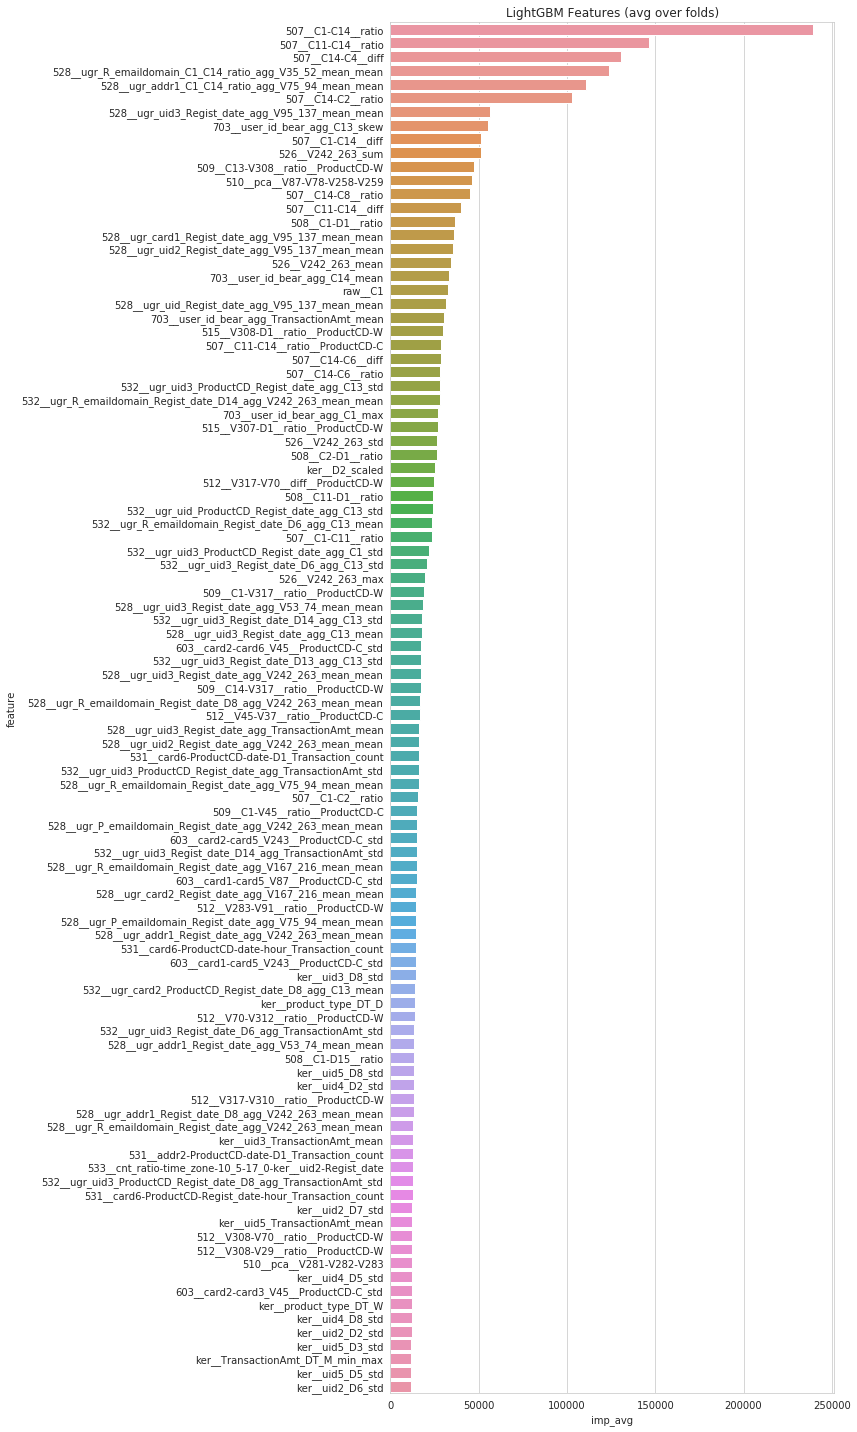

In [7]:
feim, _ = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)

In [9]:
cnt = 0
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
for feature_name in feim.index:
# for feature_name in feim.tail(100).index:
# for feature_name in feim[feim['imp_avg']<6000].index:
    
    if not feature_name.count('mean'):
        continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'raw_use'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = '../submit/re_sub'
#     from_dir = '../submit/add_feature/'
#     from_dir = 'org_use'
#     from_dir = 'valid_use'
#     from_dir = 'valid_trush'
#     to_dir = '../submit/escape'
#     to_dir = '../submit/add_feature'
#     to_dir = '../submit/add_feature'
#     to_dir = 'valid_trush'
#     to_dir = 'valid_use'
#     to_dir = 'raw_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
#     to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
#         print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
        cnt+=1
    except FileNotFoundError:
        print(feature_name)
print(cnt)

NameError: name 'feim' is not defined

In [ ]:
is_submit = [True, False][0]
has_dec = [True, False][0]
n_splits = 6
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# 2017-12抜いてみる
# if not has_dec:
#     tmp_train = tmp_train[tmp_train[COLUMN_GROUP]!='2017-12']
#     Y = Y.loc[tmp_train.index]
#     n_splits = 5


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.7,
    'subsample_freq': 1,
    'colsample_bytree' : 0.10,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
#     params['learning_rate'] = 0.05
    params["early_stopping_rounds"] = 100

logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)
feim = list_result_feim[0]

  * Diff Features: 1


2019-09-29 06:04:52,252 func.utils 111 [INFO]    [<module>] * EXP: dataset new_set (590540, 1682) lr 0.01  


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.905843
[400]	valid_0's auc: 0.919909
[600]	valid_0's auc: 0.926924
[800]	valid_0's auc: 0.930362


In [8]:
pd.Series(read_pkl_gzip('../submit/ker__DeviceType_train.gz')).value_counts()

2.0    449730
0.0     85165
1.0     55645
dtype: int64